#### Load the data and necessary libraries

In [23]:
import numpy as np

y_labelled = np.load('emotion_labels.npy')
X_labelled_pca = np.load('X_labelled_pca.npy')

In [24]:
X_labelled_pca

array([[-4676.70480139, -1101.06059571,  1411.14094269, ...,
           35.28656077,    88.82657491,   -10.31369478],
       [-4666.9143598 , -1102.92070684,  1402.47794487, ...,
           35.95522192,    87.68130307,   -10.30111125],
       [-4673.5630871 , -1102.21548495,  1406.13582084, ...,
           36.33381653,    89.19787496,   -10.30507762],
       ...,
       [-4666.20520714, -1104.57691392,  1406.16822481, ...,
           34.52695015,    88.55708859,   -10.31046543],
       [-4670.49808296, -1097.16019467,  1406.16233294, ...,
           34.8802771 ,    88.64554385,   -11.17109756],
       [-4667.64907378, -1100.13245381,  1404.17203191, ...,
           35.83160958,    87.81966698,    -9.22751313]], shape=(920, 68))

#### Create SVM class definition

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

class SVMClassifier:
    def __init__(self, kernel='poly', param_grid=None, cv=5, scoring='accuracy', probability=False):
        self.param_grid = param_grid or {
            'svc__degree': [2, 3, 4],
            'svc__coef0': [0, 1, 5],
            'svc__C': [0.1, 1, 10]
        }
        self.pipeline = Pipeline([
            ('svc', SVC(kernel=kernel, class_weight='balanced', probability=probability))
        ])

        self.grid_search = GridSearchCV(self.pipeline, self.param_grid, cv=cv, scoring=scoring)
        self.best_model = None

    def fit(self, X, y):
        self.grid_search.fit(X, y)
        self.best_model = self.grid_search.best_estimator_
        print("Best Parameters:", self.grid_search.best_params_)
        print("Best Score:", self.grid_search.best_score_)

    def predict(self, X):
        if self.best_model is None:
            raise Exception("Model has not been trained. Call `.fit(X, y)` first.")
        return self.best_model.predict(X)
    
    def report(self, X, y_true):
        y_pred = self.predict(X)
        print("Classification Report:\n", classification_report(y_true, y_pred))


In [26]:
unique, counts = np.unique(y_labelled, return_counts=True)
count_dict = dict(zip(unique, counts))

for key,val in count_dict.items():
    print(f"Emotion {key} has {val} samples in the dataset")

Emotion Anger has 45 samples in the dataset
Emotion Contempt has 18 samples in the dataset
Emotion Disgust has 59 samples in the dataset
Emotion Fear has 25 samples in the dataset
Emotion Happiness has 69 samples in the dataset
Emotion Neutral has 593 samples in the dataset
Emotion Sadness has 28 samples in the dataset
Emotion Surprise has 83 samples in the dataset


1. **stratify = 'y_labeled'**

- ensures that class distribution in the train and test sets stays similar to the original data.

- Without it, the split could be random, potentially leading to some minority classes being underrepresented or even missing in one of the sets

2. **class_weight = 'balanced'**

- tells the SVM classifier to adjust the penalty (C parameter) for each class inversely proportional to its frequency in the training data

- Minority classes will be penalized more for misclassification
- Majority classes will be penalized less

why this strategy ? This helps the model to pay more attention to the underrepresented classes, improving the recall for them 

---

### Model 1 => Normal SVM training

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_labelled_pca, y_labelled, test_size=0.3, random_state=42,  stratify=y_labelled)

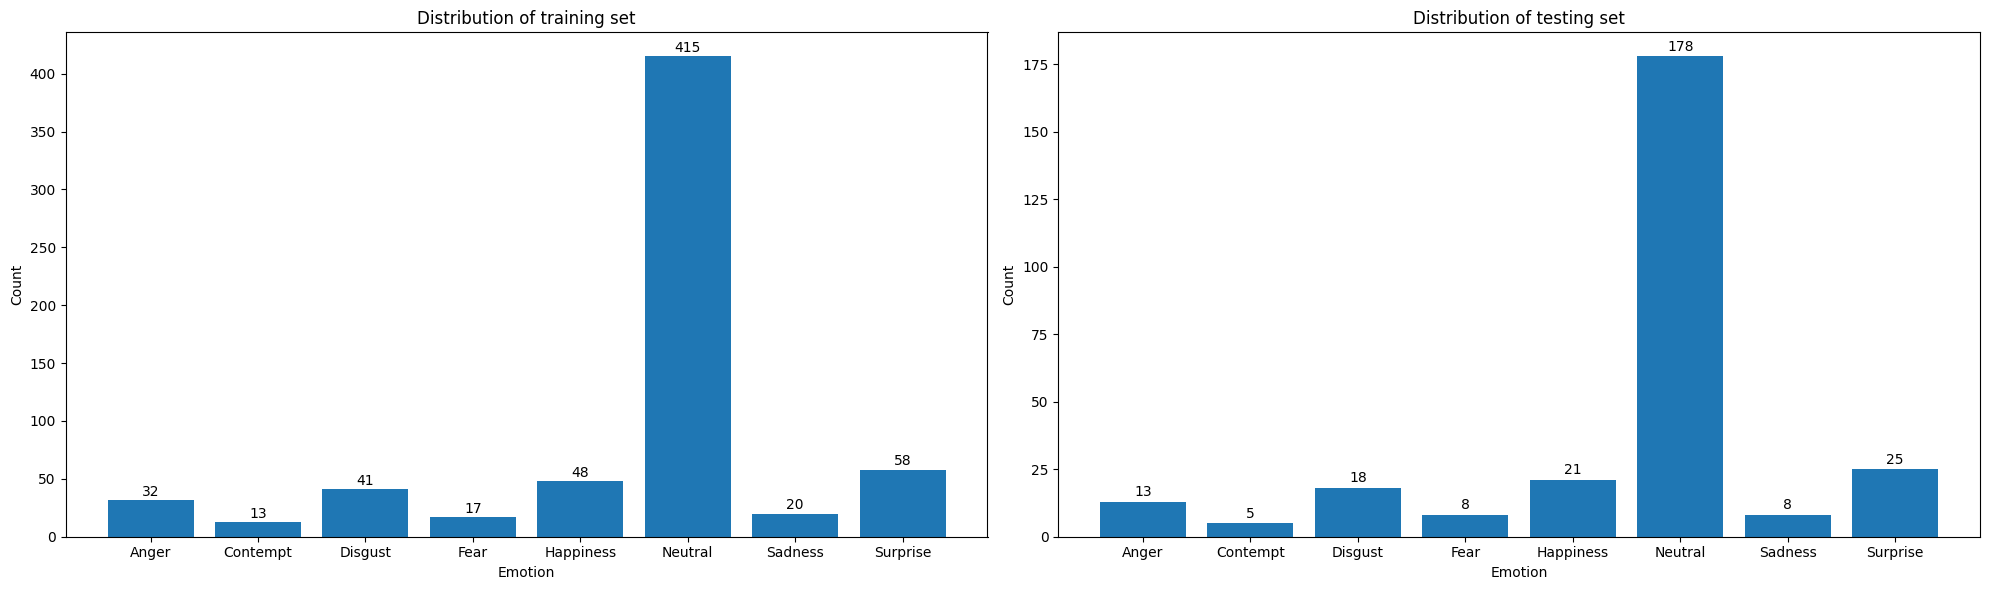

In [29]:
from matplotlib import pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=(20, 6)) 

unique, counts = np.unique(y_train, return_counts=True)
count_dict = dict(zip(unique, counts))

bars = ax[0].bar(count_dict.keys(), count_dict.values())
ax[0].set_title('Distribution of training set')
ax[0].set_xlabel('Emotion')
ax[0].set_ylabel('Count')

for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')



unique, counts = np.unique(y_test, return_counts=True)
count_dict = dict(zip(unique, counts))

bars = ax[1].bar(count_dict.keys(), count_dict.values())
ax[1].set_title('Distribution of testing set')
ax[1].set_xlabel('Emotion')
ax[1].set_ylabel('Count')

for bar in bars:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### Fit the training data to the SVM 
##### Model settings
1. stratify='y_labelled'
2. class_weight='balanced'
3. kernel = 'rbf'
4. cv = 10
5. Dimensions of input data = 68 (r value)
6. SVM scoring = 'f1_macro' 

why f1_macro ? scoring metrics such as accuracy might be misleading since its a multi-class classification task. and considering the data is skewed, the model might look good in terms of accuracy but very bad in F1 or recall for under-represented classes like "Fear" or "Disgust"

In [30]:
clf = SVMClassifier(cv=10, param_grid = {
    'svc__C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100],       
    'svc__gamma': ['scale', 0.001, 0.01, 0.1, 1] 
}, kernel='rbf', scoring='f1_macro')

In [31]:
clf.fit(X=X_train, y=y_train)

Best Parameters: {'svc__C': 70, 'svc__gamma': 0.001}
Best Score: 0.5369787587302637


In [32]:
y_pred = clf.predict(X=X_test)

In [33]:
clf.report(X=X_test, y_true=y_test)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.55      0.46      0.50        13
    Contempt       0.18      0.40      0.25         5
     Disgust       0.65      0.61      0.63        18
        Fear       1.00      0.38      0.55         8
   Happiness       0.95      0.86      0.90        21
     Neutral       0.87      0.91      0.89       178
     Sadness       0.33      0.38      0.35         8
    Surprise       0.95      0.76      0.84        25

    accuracy                           0.81       276
   macro avg       0.68      0.59      0.61       276
weighted avg       0.83      0.81      0.81       276



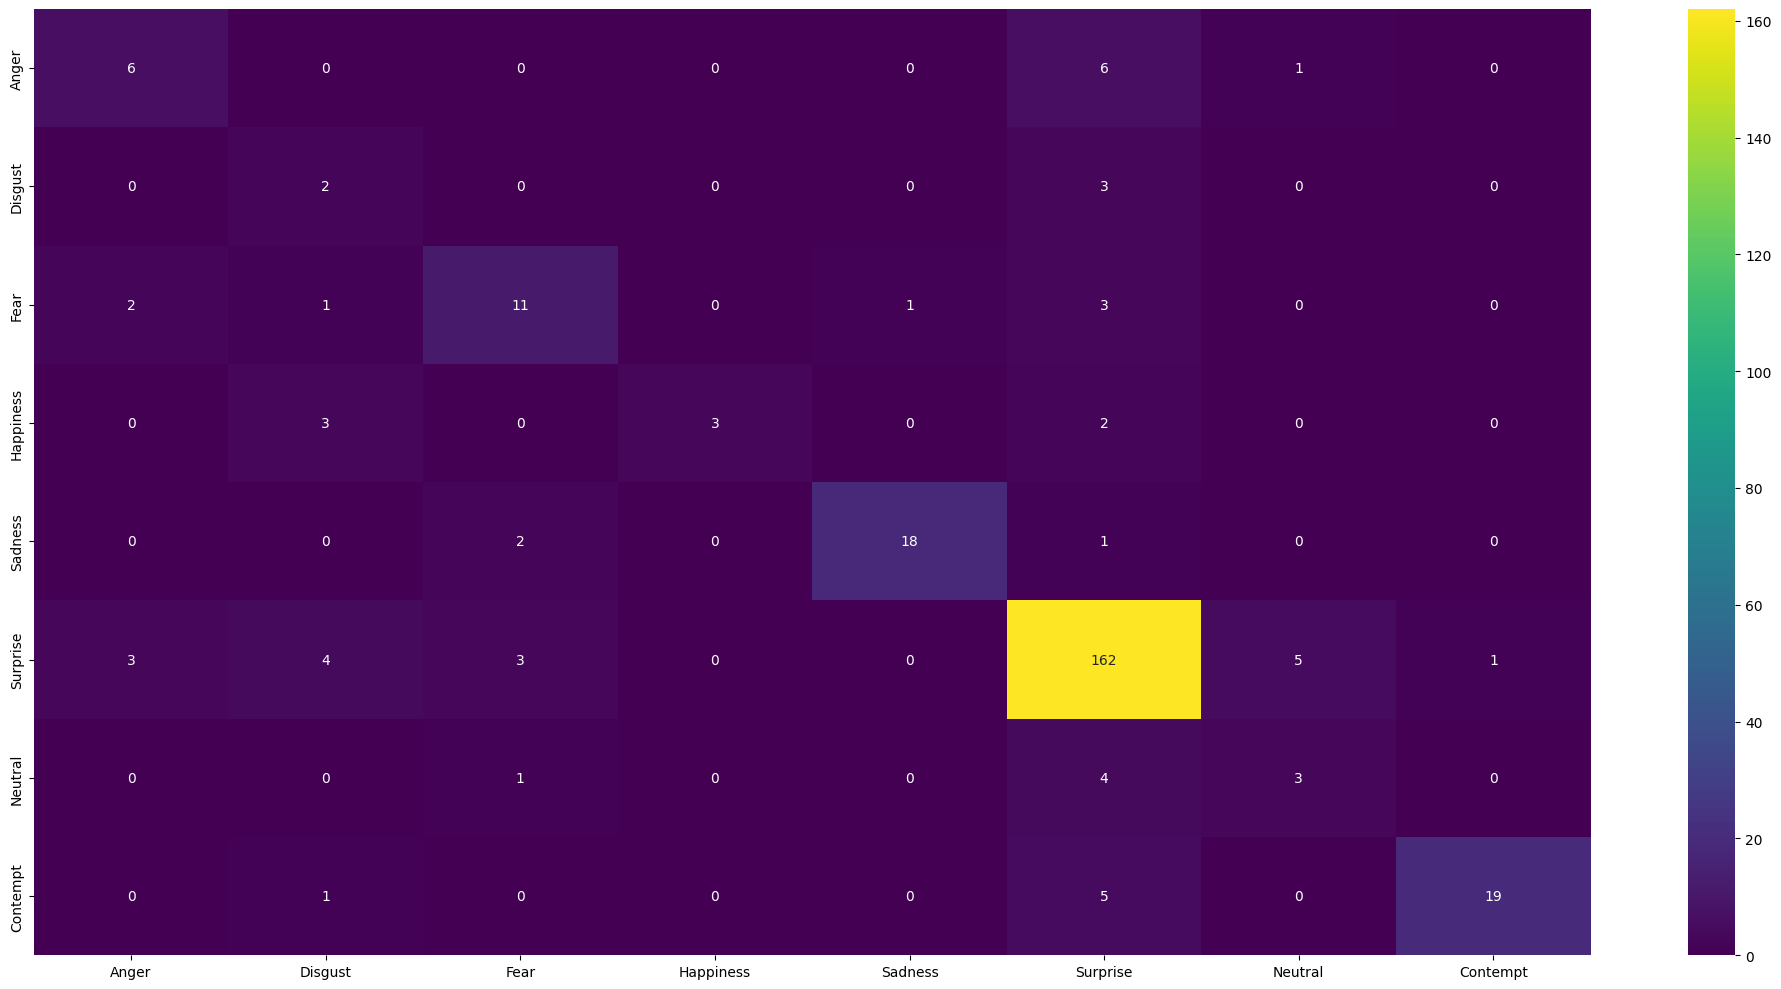

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()


#### Model 2 => Using SMOTE

Since we have a very skewed dataset,
1. It causes the model to be bias towards the dominant (highest represented) class
2. Ignores or misclassifier the under-represented class and may result high accuracy but low recall/precision/F1 for these classes


SMOTE creates synthetic samples for the under-represented class by interpolating between existing samples, instead of just duplicating them. This balances the dataset and introduces diversity to the under-represented classes

In [35]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_labelled_pca, y_labelled, test_size=0.3, random_state=42,  stratify=y_labelled)

##### Fit the training data to the SVM 
##### Model settings
1. stratify='y_labelled'
2. class_weight='balanced'
3. kernel = 'rbf'
4. cv = 10
5. Dimensions of input data = 68 (r value)
6. SVM scoring = 'f1_macro'

In [36]:
svm = SVMClassifier(cv=10, param_grid = {
    'svc__C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100],       
    'svc__gamma': ['scale', 0.001, 0.01, 0.1, 1] 
}, kernel='rbf', scoring='f1_macro')

##### Use SMOTE only on the training set

In [37]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [38]:
print(f"The dimensions of X_train is {X_train.shape}")
print(f"The dimensions of SMOTE X_train is {X_train_resampled.shape}")

The dimensions of X_train is (644, 68)
The dimensions of SMOTE X_train is (3320, 68)


In [39]:
print(f"The dimensions of y_train is {y_train.shape}")
print(f"The dimensions of SMOTE y_train is {y_train_resampled.shape}")

The dimensions of y_train is (644,)
The dimensions of SMOTE y_train is (3320,)


In [40]:
svm.fit(X=X_train_resampled, y=y_train_resampled)

Best Parameters: {'svc__C': 30, 'svc__gamma': 0.01}
Best Score: 0.9951492720108617


In [41]:
y_pred = svm.predict(X=X_test)

In [42]:
svm.report(X=X_test, y_true=y_test)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.50      0.31      0.38        13
    Contempt       0.00      0.00      0.00         5
     Disgust       0.78      0.39      0.52        18
        Fear       1.00      0.12      0.22         8
   Happiness       0.94      0.71      0.81        21
     Neutral       0.79      0.96      0.87       178
     Sadness       0.00      0.00      0.00         8
    Surprise       0.89      0.68      0.77        25

    accuracy                           0.78       276
   macro avg       0.61      0.40      0.45       276
weighted avg       0.77      0.78      0.75       276



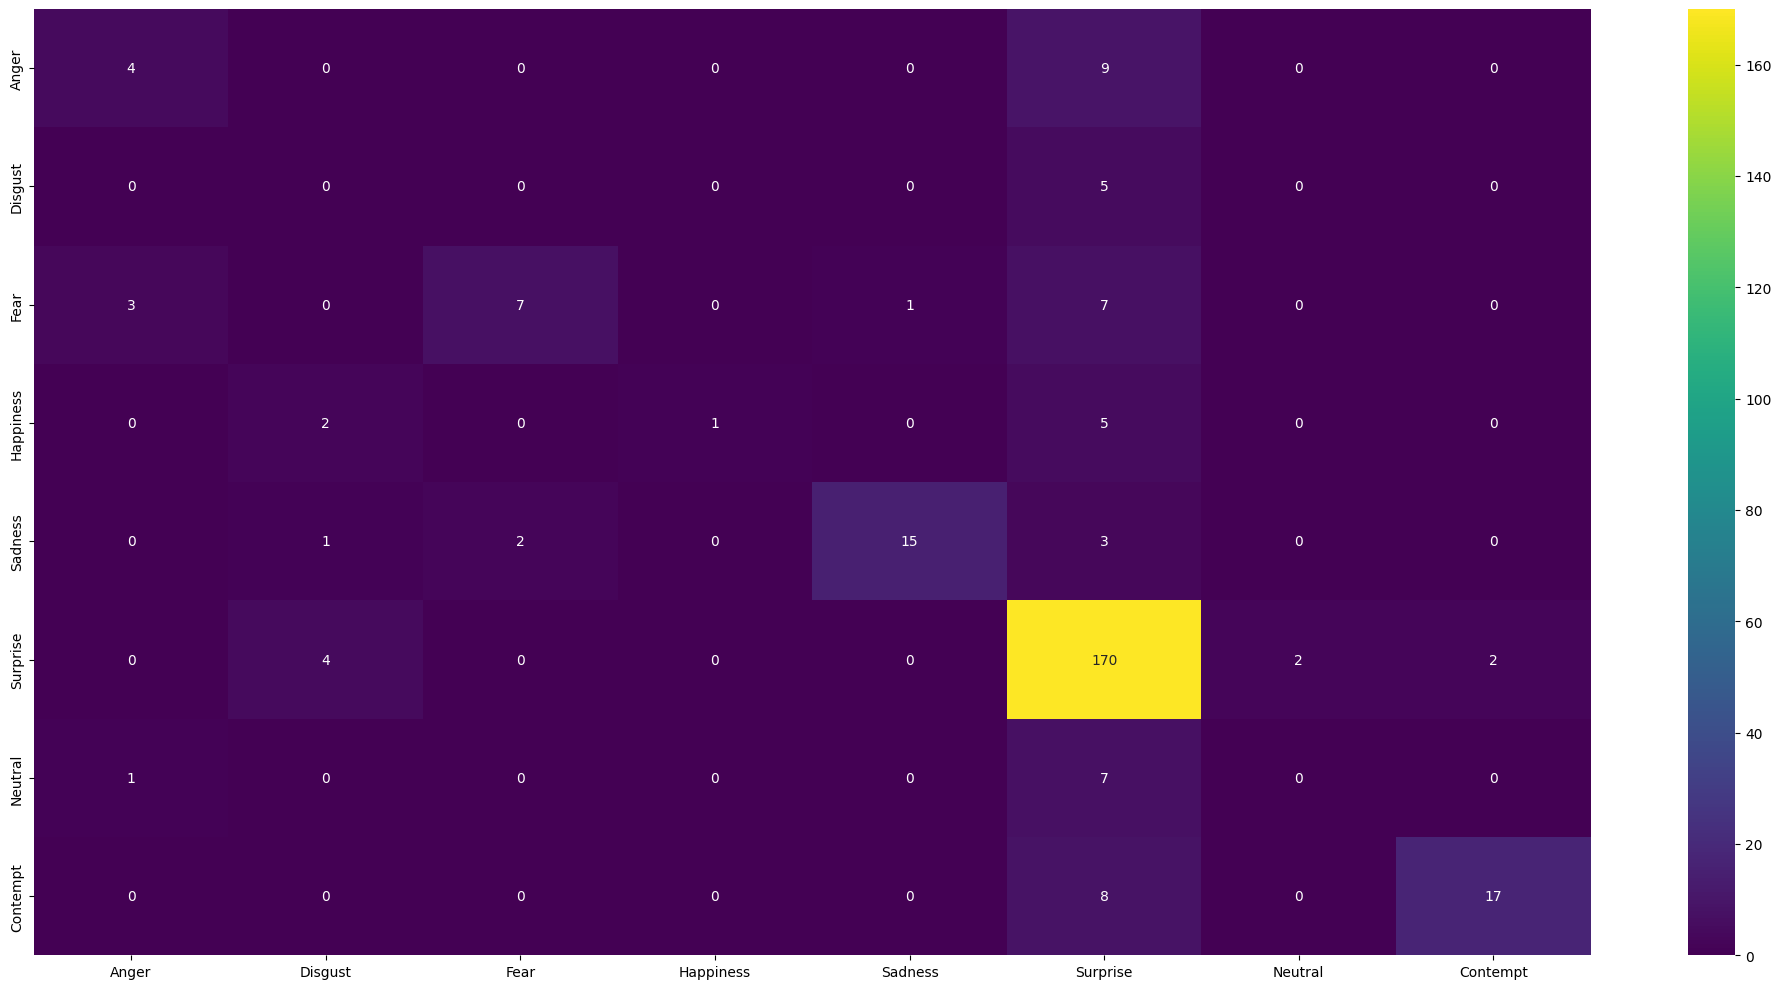

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()


#### Model 3 => Using a subset

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_labelled_pca, y_labelled, test_size=0.3, stratify=y_labelled, random_state=42)

X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.3, stratify=y_train, random_state=42)

##### Fit the training data to the SVM 
##### Model settings
1. stratify='y_labelled'
2. class_weight='balanced'
3. kernel = 'rbf'
4. cv = 10
5. Dimensions of input data = 68 (r value)
6. SVM scoring = 'f1_macro'

In [45]:
svm = SVMClassifier(cv=10, param_grid = {
    'svc__C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100],       
    'svc__gamma': ['scale', 0.001, 0.01, 0.1, 1] 
}, kernel='rbf', scoring='f1_macro')

In [46]:
svm.fit(X=X_train_sub, y=y_train_sub)

C:\Users\Nkris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}
Best Score: 0.40335568201639627


In [47]:
y_pred = svm.predict(X=X_test)

In [48]:
svm.report(X=X_test, y_true=y_test)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.16      0.31      0.21        13
    Contempt       0.20      0.40      0.27         5
     Disgust       0.65      0.61      0.63        18
        Fear       0.00      0.00      0.00         8
   Happiness       0.94      0.81      0.87        21
     Neutral       0.83      0.85      0.84       178
     Sadness       0.00      0.00      0.00         8
    Surprise       1.00      0.72      0.84        25

    accuracy                           0.74       276
   macro avg       0.47      0.46      0.46       276
weighted avg       0.75      0.74      0.74       276



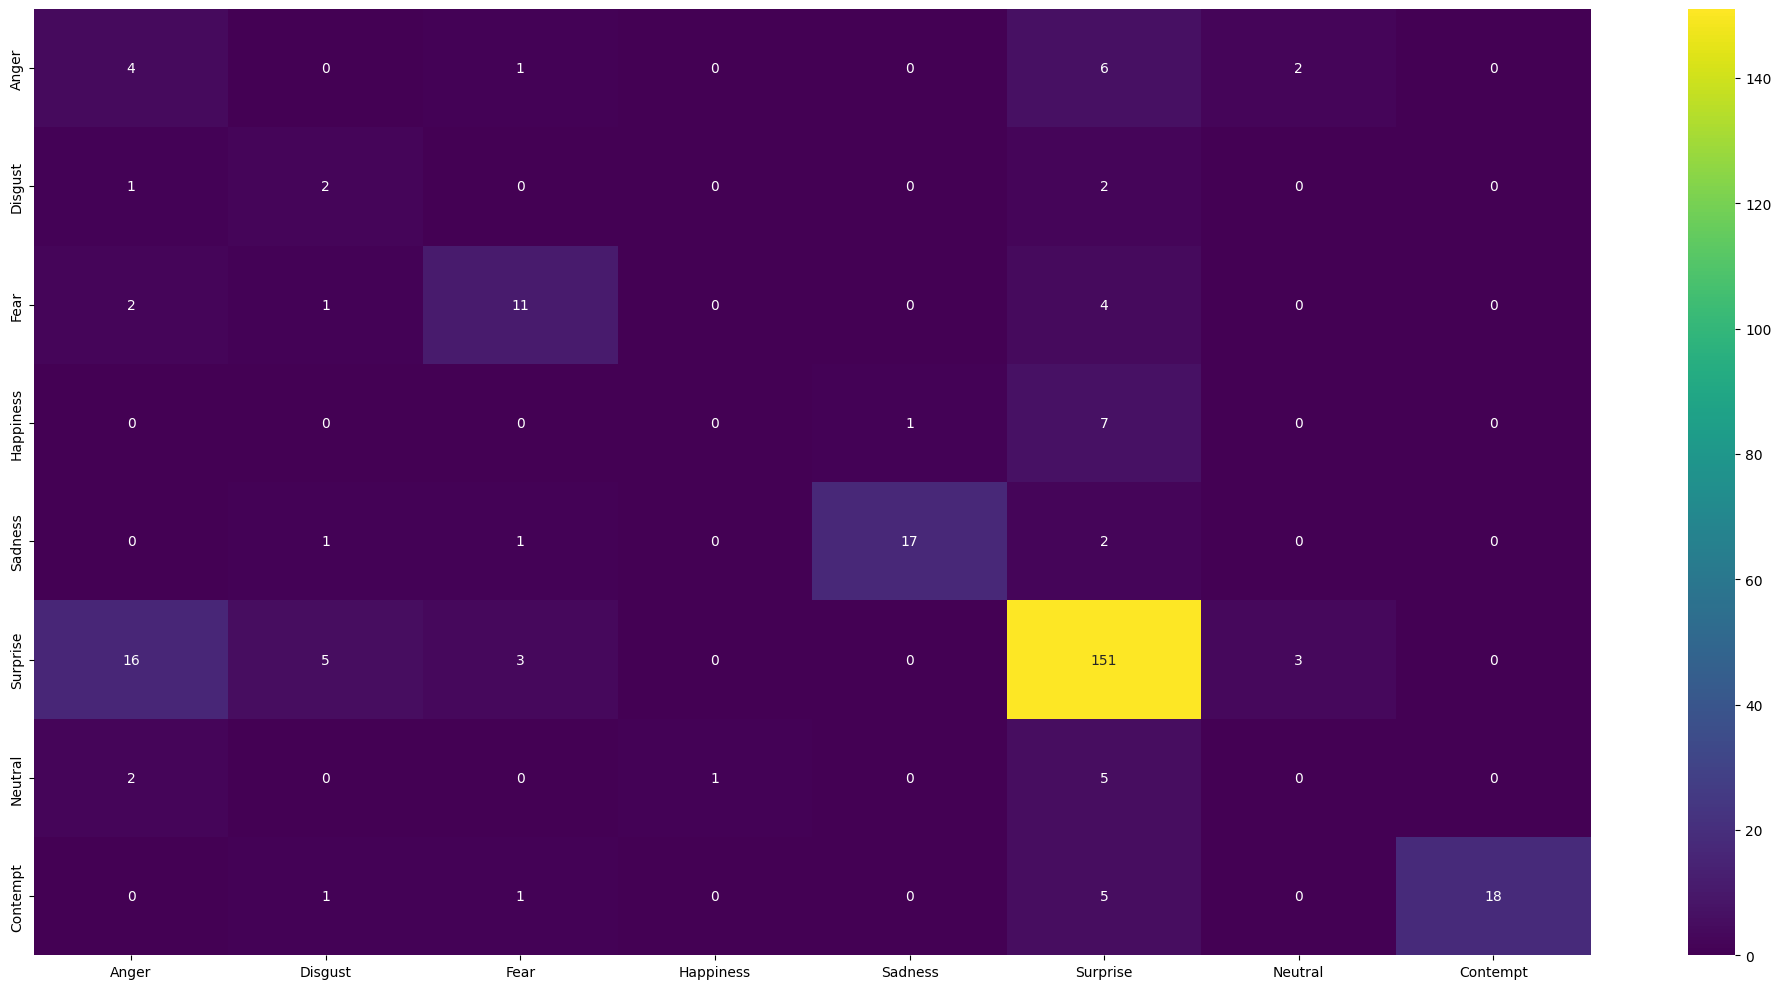

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()


Extracting a subset, does not seem to improve the model because the subset further reduces the entries in the under-represented class making the model to fail to perform better in the under-represented class

#### Model 4 => Another variation of Subset

In [50]:
from sklearn.utils import resample
import pandas as pd

df = pd.DataFrame(X_labelled_pca)
df['label'] = y_labelled

neutral_df = df[df['label'] == 'Neutral']
minority_df = df[df['label'] != 'Neutral']

minority_counts = df[df['label'] != 'Neutral']['label'].value_counts()
max_minority = minority_counts.max()

neutral_downsampled = resample(neutral_df, 
                               replace=False, 
                               n_samples=max_minority, 
                               random_state=42)

balanced_subset = pd.concat([neutral_downsampled, minority_df])
balanced_subset = balanced_subset.sample(frac=1, random_state=42) 

X_subset = balanced_subset.drop('label', axis=1).values
y_subset = balanced_subset['label'].values

In [51]:
df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,label
0,-4676.704801,-1101.060596,1411.140943,-36.067306,-2424.009484,-1983.232100,-993.553149,-760.498575,-203.166513,-172.486788,...,9.849031,28.082791,-54.053593,-80.005112,16.937249,13.298290,35.286561,88.826575,-10.313695,Neutral
1,-4666.914360,-1102.920707,1402.477945,-36.308498,-2415.429973,-1975.635271,-990.888497,-758.442583,-203.459622,-170.855262,...,7.954278,28.717099,-54.972020,-80.267085,15.836995,13.376030,35.955222,87.681303,-10.301111,Neutral
2,-4673.563087,-1102.215485,1406.135821,-34.214683,-2416.284763,-1979.622342,-992.145120,-755.199860,-205.028095,-169.054748,...,9.279799,28.051932,-54.807618,-80.046300,16.299662,12.815919,36.333817,89.197875,-10.305078,Neutral
3,-4662.957839,-1104.103753,1406.178407,-35.499212,-2413.366465,-1977.296960,-991.469182,-758.122898,-203.976297,-169.115186,...,9.201661,29.445880,-54.830933,-80.839228,16.649937,13.138352,35.585600,88.254118,-10.396047,Neutral
4,-4666.729198,-1104.032582,1408.120315,-36.865712,-2416.630949,-1981.293667,-992.482363,-757.820587,-202.742730,-171.003113,...,8.172443,29.468981,-54.969272,-80.875524,16.955686,13.756811,34.999183,88.744326,-10.850136,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,-4661.502708,-1103.613706,1412.009895,-38.557374,-2414.259599,-1980.238447,-992.735944,-758.556203,-204.099735,-169.327956,...,8.968060,28.317366,-53.897174,-78.336447,16.823758,13.216713,35.288606,89.482312,-10.435487,Surprise
916,-4680.740735,-1104.889640,1409.471641,-36.310820,-2423.025890,-1983.462143,-993.657728,-759.033017,-203.324167,-171.336576,...,8.446073,28.869112,-54.463947,-80.183597,17.159683,13.495816,35.249526,88.532558,-10.798324,Surprise
917,-4666.205207,-1104.576914,1406.168225,-36.606286,-2417.290717,-1978.693612,-992.164331,-760.650479,-203.437497,-171.828848,...,8.908062,27.918267,-54.553454,-79.571815,17.619996,14.155225,34.526950,88.557089,-10.310465,Surprise
918,-4670.498083,-1097.160195,1406.162333,-37.123157,-2421.015326,-1973.228105,-989.876259,-759.127169,-204.753258,-171.494333,...,8.753220,28.868586,-54.190147,-79.315328,15.898305,14.206786,34.880277,88.645544,-11.171098,Surprise


In [52]:
balanced_subset

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,label
682,-4666.794483,-1105.084228,1408.526469,-37.658972,-2413.897236,-1980.527495,-992.704993,-756.663571,-203.212267,-169.339061,...,8.207685,29.255257,-55.020967,-80.504662,16.485877,13.570948,35.531209,88.648757,-10.560972,Anger
647,-4664.139722,-1104.552029,1408.985547,-36.042566,-2412.490301,-1978.726430,-990.599277,-757.210787,-202.954272,-170.013295,...,8.687064,28.418931,-53.566446,-80.089426,17.506020,12.841128,35.696864,89.171390,-10.094865,Happiness
636,-4667.046010,-1101.432887,1407.153514,-36.123401,-2413.988734,-1976.869589,-990.192542,-757.596606,-202.288540,-172.295427,...,6.799315,27.678156,-54.625245,-80.616916,18.003718,13.332402,35.901015,88.298019,-9.346129,Happiness
604,-4673.414792,-1104.401781,1407.706118,-36.062247,-2417.673974,-1979.319392,-991.143036,-757.868417,-203.201524,-170.249643,...,7.896479,27.316136,-53.562792,-80.145557,17.243545,13.804052,35.147369,87.671952,-9.718324,Happiness
78,-4665.757236,-1103.976987,1405.437663,-36.365435,-2413.572923,-1979.812807,-992.307068,-757.264785,-204.884893,-168.542283,...,8.583069,29.522922,-54.964026,-80.582357,15.750660,12.829490,35.665032,88.618967,-10.511746,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,-4666.982193,-1100.891267,1401.881636,-34.111158,-2413.801687,-1977.886055,-991.285701,-754.205293,-205.180977,-167.650795,...,9.522656,28.969273,-54.388973,-79.551868,16.061569,14.025844,35.318333,88.594100,-10.241333,Neutral
616,-4668.708863,-1104.834534,1408.622189,-37.314293,-2414.778725,-1980.797637,-991.458318,-756.193348,-202.469419,-170.527285,...,8.296048,28.306856,-53.612708,-80.473136,17.438741,13.131714,35.665509,88.748894,-10.320817,Happiness
780,-4679.494911,-1109.891662,1410.683153,-35.605436,-2419.612626,-1983.495077,-994.527580,-758.822660,-204.099944,-169.401834,...,8.622383,29.209795,-54.423478,-80.131230,16.631102,13.646111,35.289922,88.224988,-10.821274,Disgust
858,-4674.803686,-1103.083913,1405.417888,-32.536987,-2414.560112,-1976.731674,-992.644326,-758.122332,-204.152216,-169.131327,...,9.289184,28.881651,-55.215929,-79.199720,16.604625,12.875902,34.776789,88.305073,-10.674496,Surprise


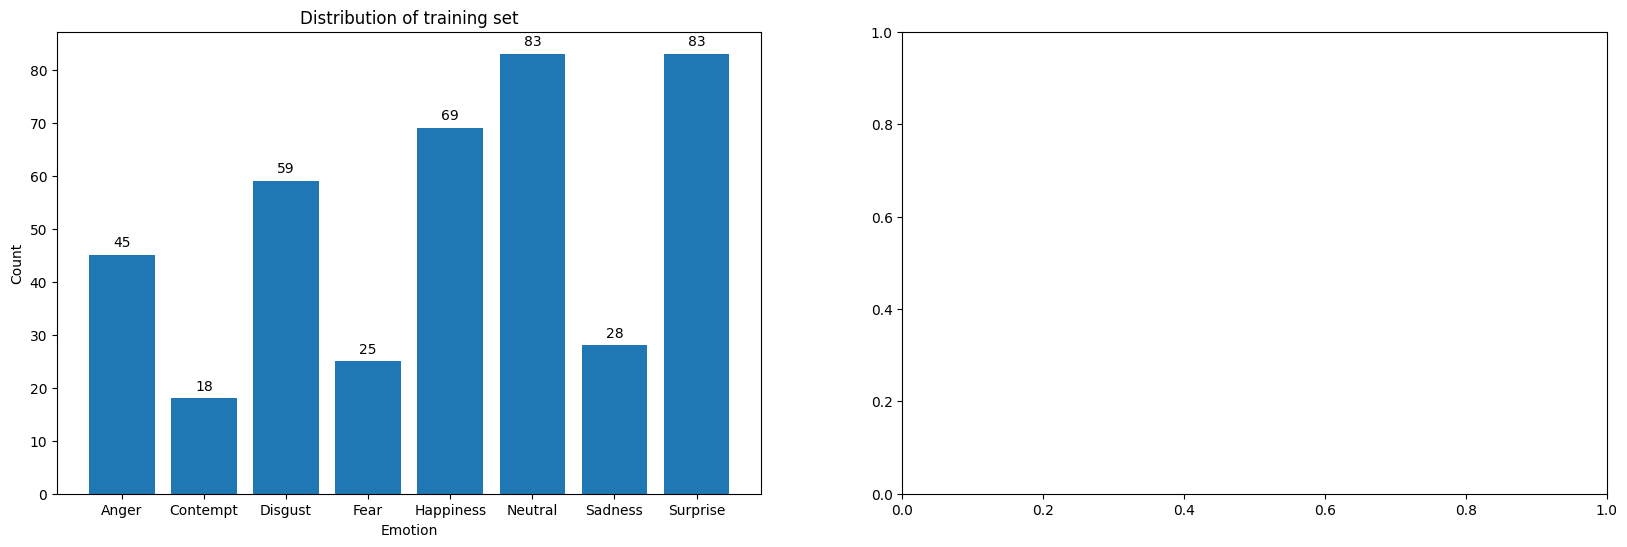

In [53]:
from matplotlib import pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=(20, 6)) 

unique, counts = np.unique(y_subset, return_counts=True)
count_dict = dict(zip(unique, counts))

bars = ax[0].bar(count_dict.keys(), count_dict.values())
ax[0].set_title('Distribution of training set')
ax[0].set_xlabel('Emotion')
ax[0].set_ylabel('Count')

for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')




In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, stratify=y_subset, random_state=42)

In [55]:
svm = SVMClassifier(cv=10, param_grid = {
    'svc__C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100],       
    'svc__gamma': ['scale', 0.001, 0.01, 0.1, 1] 
}, kernel='rbf', scoring='f1_macro')

In [56]:
svm.fit(X=X_train, y=y_train)

Best Parameters: {'svc__C': 90, 'svc__gamma': 0.001}
Best Score: 0.5394785422910424


In [57]:
y_pred = svm.predict(X=X_test)

In [58]:
svm.report(X=X_test, y_true=y_test)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.32      0.50      0.39        14
    Contempt       0.40      0.40      0.40         5
     Disgust       0.67      0.67      0.67        18
        Fear       0.60      0.43      0.50         7
   Happiness       0.90      0.90      0.90        21
     Neutral       0.59      0.52      0.55        25
     Sadness       0.60      0.75      0.67         8
    Surprise       0.95      0.76      0.84        25

    accuracy                           0.66       123
   macro avg       0.63      0.62      0.62       123
weighted avg       0.69      0.66      0.67       123



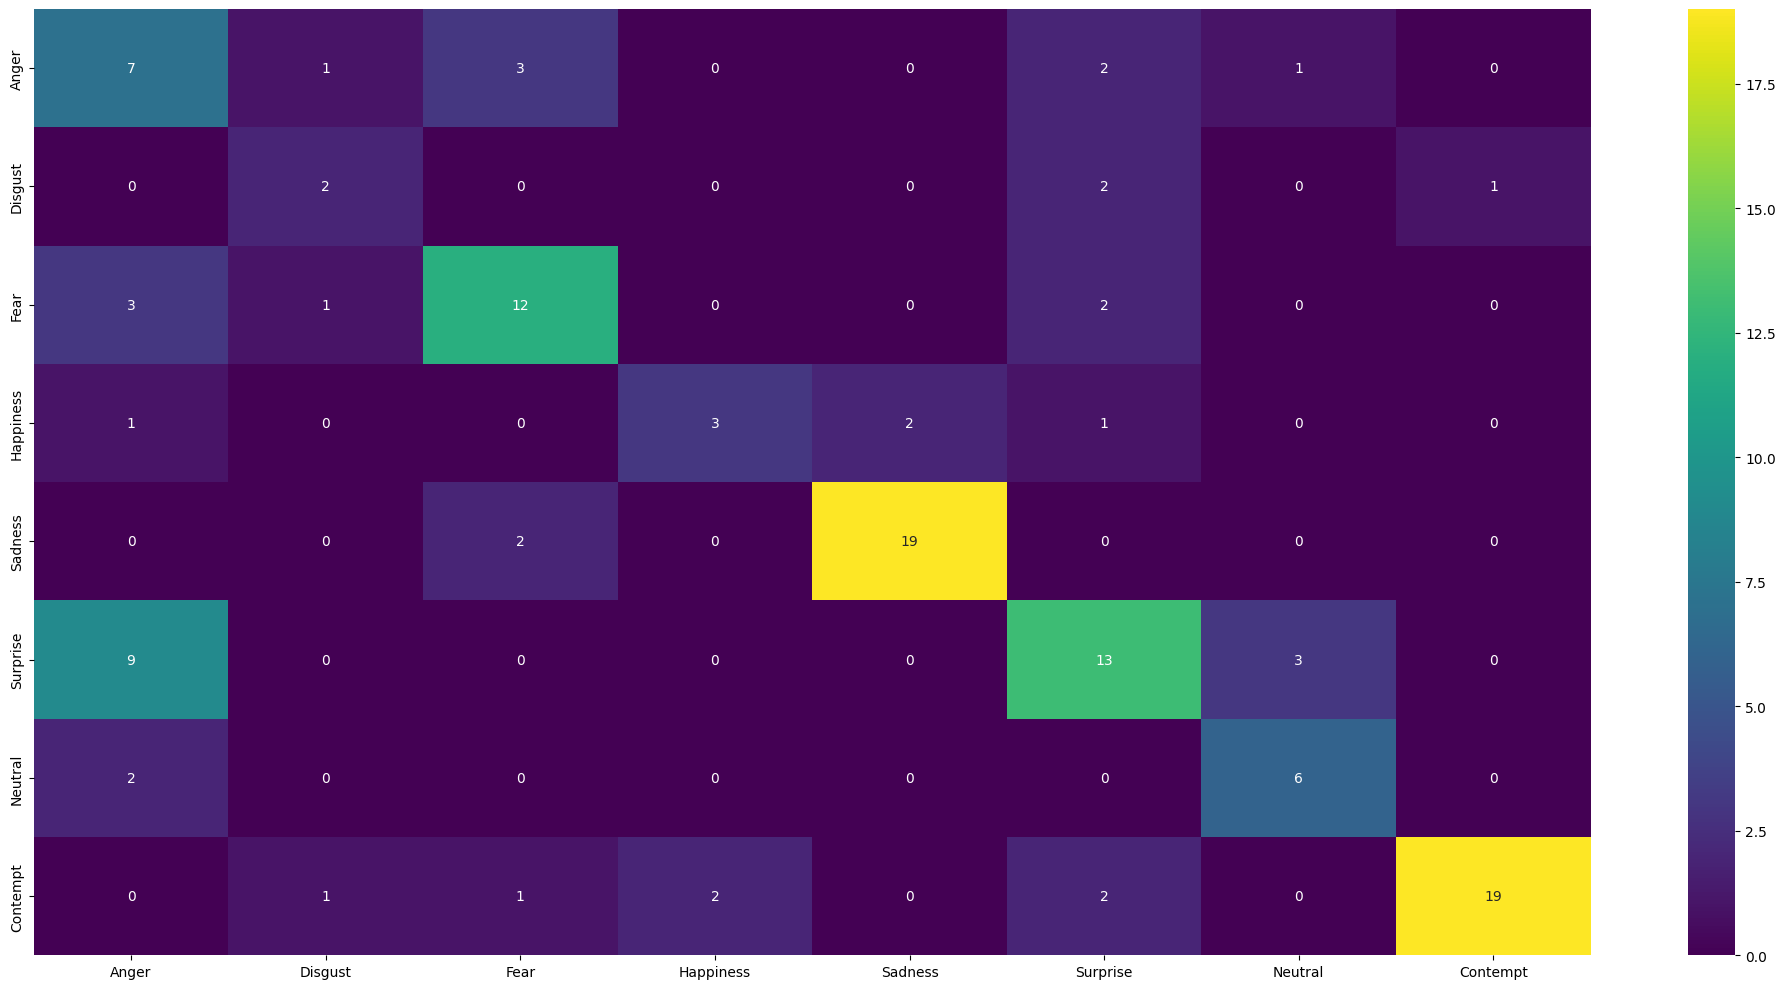

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()


- "Neutral" class no longer dominates the predictions and the model is giving more attention to the minority classes like "Anger", "Sadness" and "Surprise"
- 'Happiness': precision=0.90, recall=0.90 → model is very good at detecting it.
- 'Surprise': strong f1-score of 0.84

#### Model 5 => Using SMOTE + v2 of Subset

In [60]:
from sklearn.utils import resample
import pandas as pd

df = pd.DataFrame(X_labelled_pca)
df['label'] = y_labelled

neutral_df = df[df['label'] == 'Neutral']
minority_df = df[df['label'] != 'Neutral']

minority_counts = df[df['label'] != 'Neutral']['label'].value_counts()
max_minority = minority_counts.max()

neutral_downsampled = resample(neutral_df, 
                               replace=False, 
                               n_samples=max_minority, 
                               random_state=42)

balanced_subset = pd.concat([neutral_downsampled, minority_df])
balanced_subset = balanced_subset.sample(frac=1, random_state=42) 

X_subset = balanced_subset.drop('label', axis=1).values
y_subset = balanced_subset['label'].values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, stratify=y_subset, random_state=42)

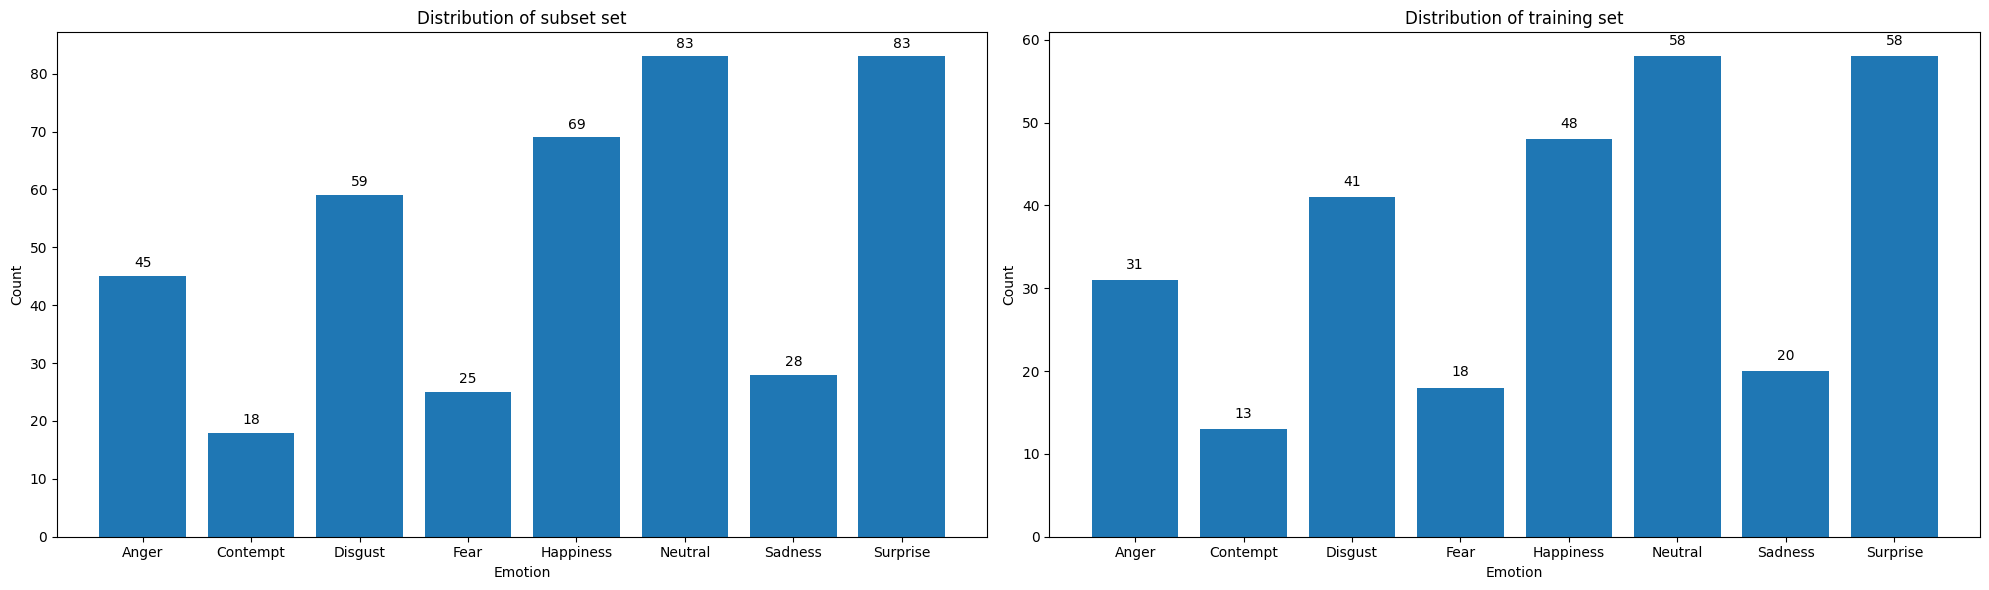

In [62]:
from matplotlib import pyplot as plt 
fig, ax = plt.subplots(1, 2, figsize=(20, 6)) 

unique, counts = np.unique(y_subset, return_counts=True)
count_dict = dict(zip(unique, counts))

bars = ax[0].bar(count_dict.keys(), count_dict.values())
ax[0].set_title('Distribution of subset set')
ax[0].set_xlabel('Emotion')
ax[0].set_ylabel('Count')

for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')

unique, counts = np.unique(y_train, return_counts=True)
count_dict = dict(zip(unique, counts))

bars = ax[1].bar(count_dict.keys(), count_dict.values())
ax[1].set_title('Distribution of training set')
ax[1].set_xlabel('Emotion')
ax[1].set_ylabel('Count')

for bar in bars:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom')

plt.tight_layout()
plt.show()


##### Fit the training data to the SVM 
##### Model settings
1. stratify='y_labelled'
2. class_weight='balanced'
3. kernel = 'rbf'
4. cv = 10
5. Dimensions of input data = 68 (r value)
6. SVM scoring = 'f1_macro'

In [63]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [64]:
print(f"The dimensions of X_train is {X_train.shape}")
print(f"The dimensions of SMOTE X_train is {X_train_resampled.shape}")

The dimensions of X_train is (287, 68)
The dimensions of SMOTE X_train is (464, 68)


In [65]:
print(f"The dimensions of y_train is {y_train.shape}")
print(f"The dimensions of SMOTE y_train is {y_train_resampled.shape}")

The dimensions of y_train is (287,)
The dimensions of SMOTE y_train is (464,)


In [66]:
svm.fit(X=X_train_resampled, y=y_train_resampled)

Best Parameters: {'svc__C': 90, 'svc__gamma': 0.001}
Best Score: 0.8906138306138308


In [67]:
y_pred = svm.predict(X=X_test)

In [68]:
svm.report(X=X_test, y_true=y_test)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.32      0.50      0.39        14
    Contempt       0.25      0.20      0.22         5
     Disgust       0.63      0.67      0.65        18
        Fear       0.67      0.57      0.62         7
   Happiness       0.90      0.90      0.90        21
     Neutral       0.57      0.48      0.52        25
     Sadness       0.50      0.62      0.56         8
    Surprise       0.95      0.76      0.84        25

    accuracy                           0.64       123
   macro avg       0.60      0.59      0.59       123
weighted avg       0.67      0.64      0.65       123



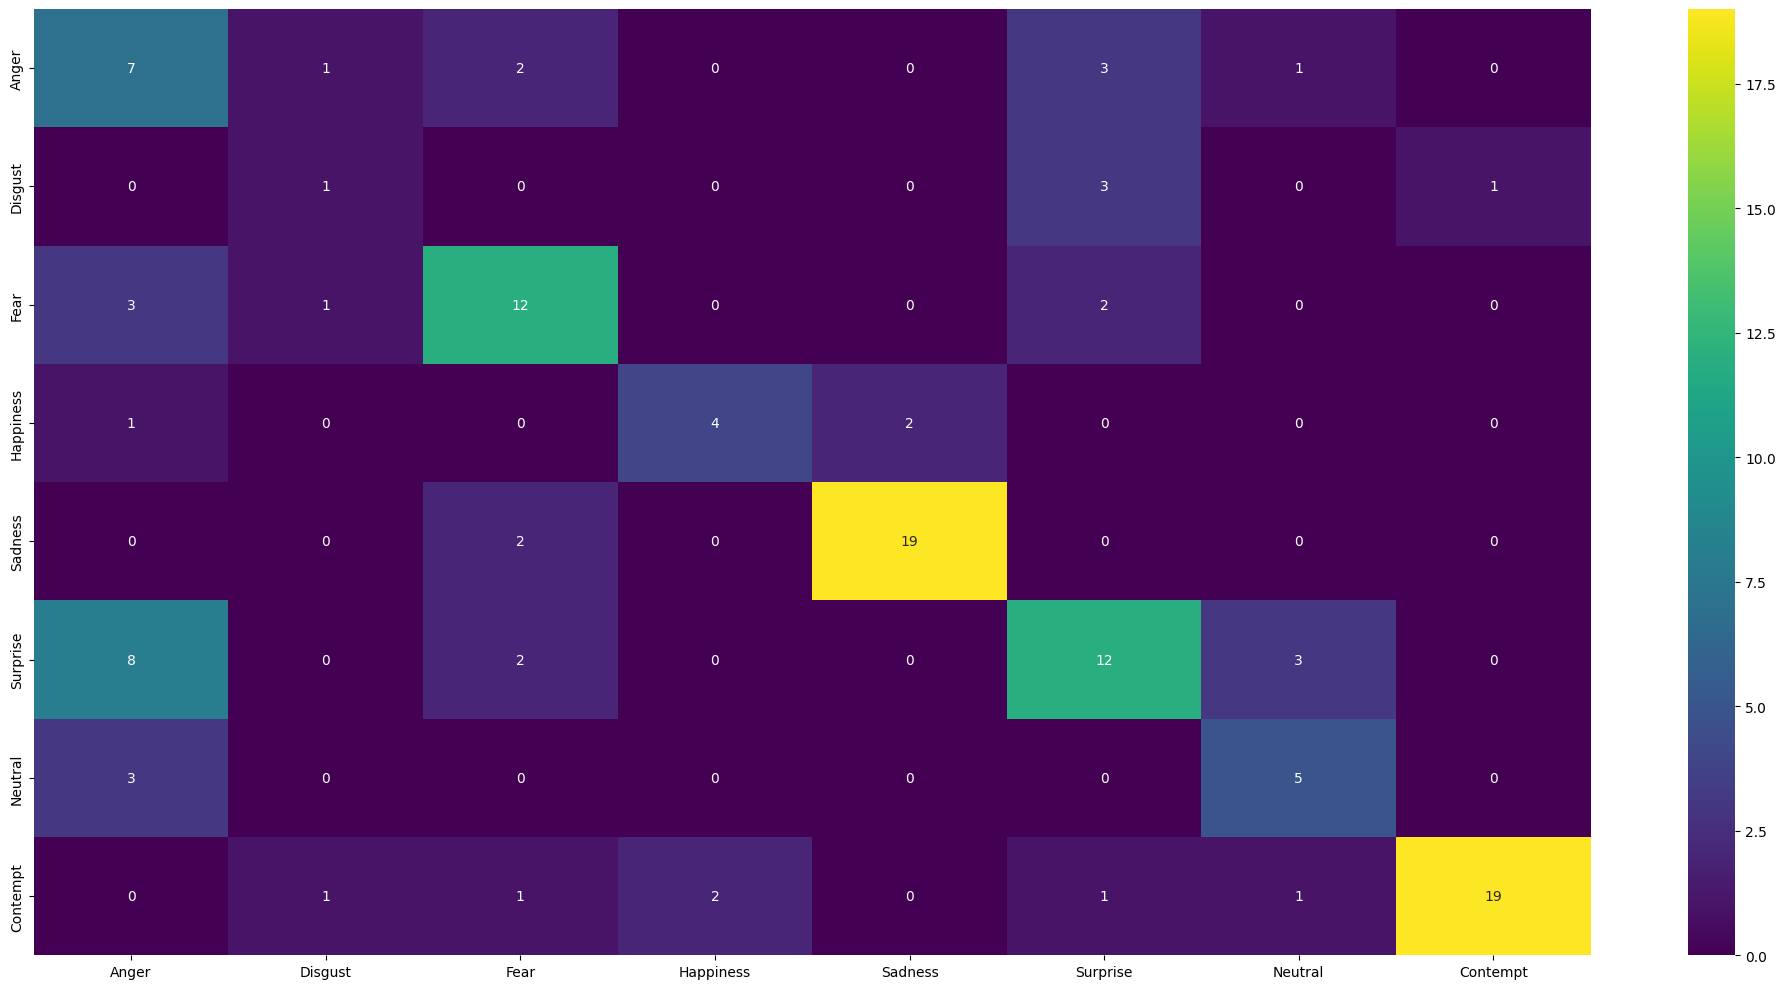

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()


#### Model 6 

#### First we take the entire dataset
1. Split into train and test
2. for the first model consider it as neutral and non-neutral and train the model
3. for the second model consider only the samples that are not neutral and train the model
4. Now for the testing set obtained in step 1, pass it to both model1 and model2, if it predicts "Neutral" from model1, accept it because the model was highly biased towards the neutral side. If it says non-neutral, then consider the prediction made by model2


In [70]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_labelled_pca, y_labelled, stratify=y_labelled, test_size=0.3)

In [71]:
svm1_x = X_train_final
svm1_y = np.array(['NotNeutral' if val != 'Neutral' else 'Neutral' for val in y_train_final])


In [72]:
### Train model 1

X_train, X_test, y_train, y_test = train_test_split(svm1_x, svm1_y, test_size=0.3, random_state=42,  stratify=svm1_y)

svm_1 = SVMClassifier(cv=10, param_grid = {
    'svc__C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100],       
    'svc__gamma': ['scale', 0.001, 0.01, 0.1, 1] 
}, kernel='rbf', scoring='f1_macro', probability=True)

svm_1.fit(X=X_train, y=y_train)

Best Parameters: {'svc__C': 100, 'svc__gamma': 0.01}
Best Score: 0.7762477118566556


In [73]:
svm_1.report(X=X_test, y_true=y_test)

Classification Report:
               precision    recall  f1-score   support

     Neutral       0.79      0.89      0.83       125
  NotNeutral       0.74      0.57      0.64        69

    accuracy                           0.77       194
   macro avg       0.76      0.73      0.74       194
weighted avg       0.77      0.77      0.77       194



In [74]:
### Train model 2
df1 = pd.DataFrame(X_train_final)
df1['label'] = y_train_final

other_df = df1[df1['label'] != 'Neutral']

other_df = other_df.sample(frac=1, random_state=42) 

X_subset = other_df.drop('label', axis=1).values
y_subset = other_df['label'].values


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42,  stratify=y_subset)

svm_2 = SVMClassifier(cv=10, param_grid = {
    'svc__C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90,  100],       
    'svc__gamma': ['scale', 0.001, 0.01, 0.1, 1] 
}, kernel='rbf', scoring='f1_macro')

In [75]:
svm_2.fit(X=X_train_2, y=y_train_2)

C:\Users\Nkris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Best Parameters: {'svc__C': 80, 'svc__gamma': 0.001}
Best Score: 0.5381292517006803


In [76]:
svm_2.report(X=X_test_2, y_true=y_test_2)

Classification Report:
               precision    recall  f1-score   support

       Anger       0.60      0.67      0.63         9
    Contempt       0.50      0.75      0.60         4
     Disgust       0.62      0.67      0.64        12
        Fear       0.20      0.20      0.20         5
   Happiness       0.93      0.87      0.90        15
     Sadness       0.17      0.17      0.17         6
    Surprise       0.87      0.72      0.79        18

    accuracy                           0.65        69
   macro avg       0.55      0.58      0.56        69
weighted avg       0.67      0.65      0.66        69



##### Evaluate the model

In [77]:
final_pred = []

for i in range(len(X_test_final)):
    x = X_test_final[i].reshape(1, -1)

    pred1 = svm_1.predict(x)[0]

    if(pred1 == "Neutral"):
        final_pred.append("Neutral")
    else:
        pred2 = svm_2.predict(x)[0]
        final_pred.append(pred2)

In [78]:
print(classification_report(y_pred=final_pred, y_true=y_test_final))

              precision    recall  f1-score   support

       Anger       0.38      0.36      0.37        14
    Contempt       0.00      0.00      0.00         5
     Disgust       0.41      0.39      0.40        18
        Fear       0.00      0.00      0.00         7
   Happiness       0.88      0.67      0.76        21
     Neutral       0.81      0.90      0.85       178
     Sadness       0.00      0.00      0.00         8
    Surprise       0.94      0.68      0.79        25

    accuracy                           0.74       276
   macro avg       0.43      0.37      0.40       276
weighted avg       0.72      0.74      0.72       276



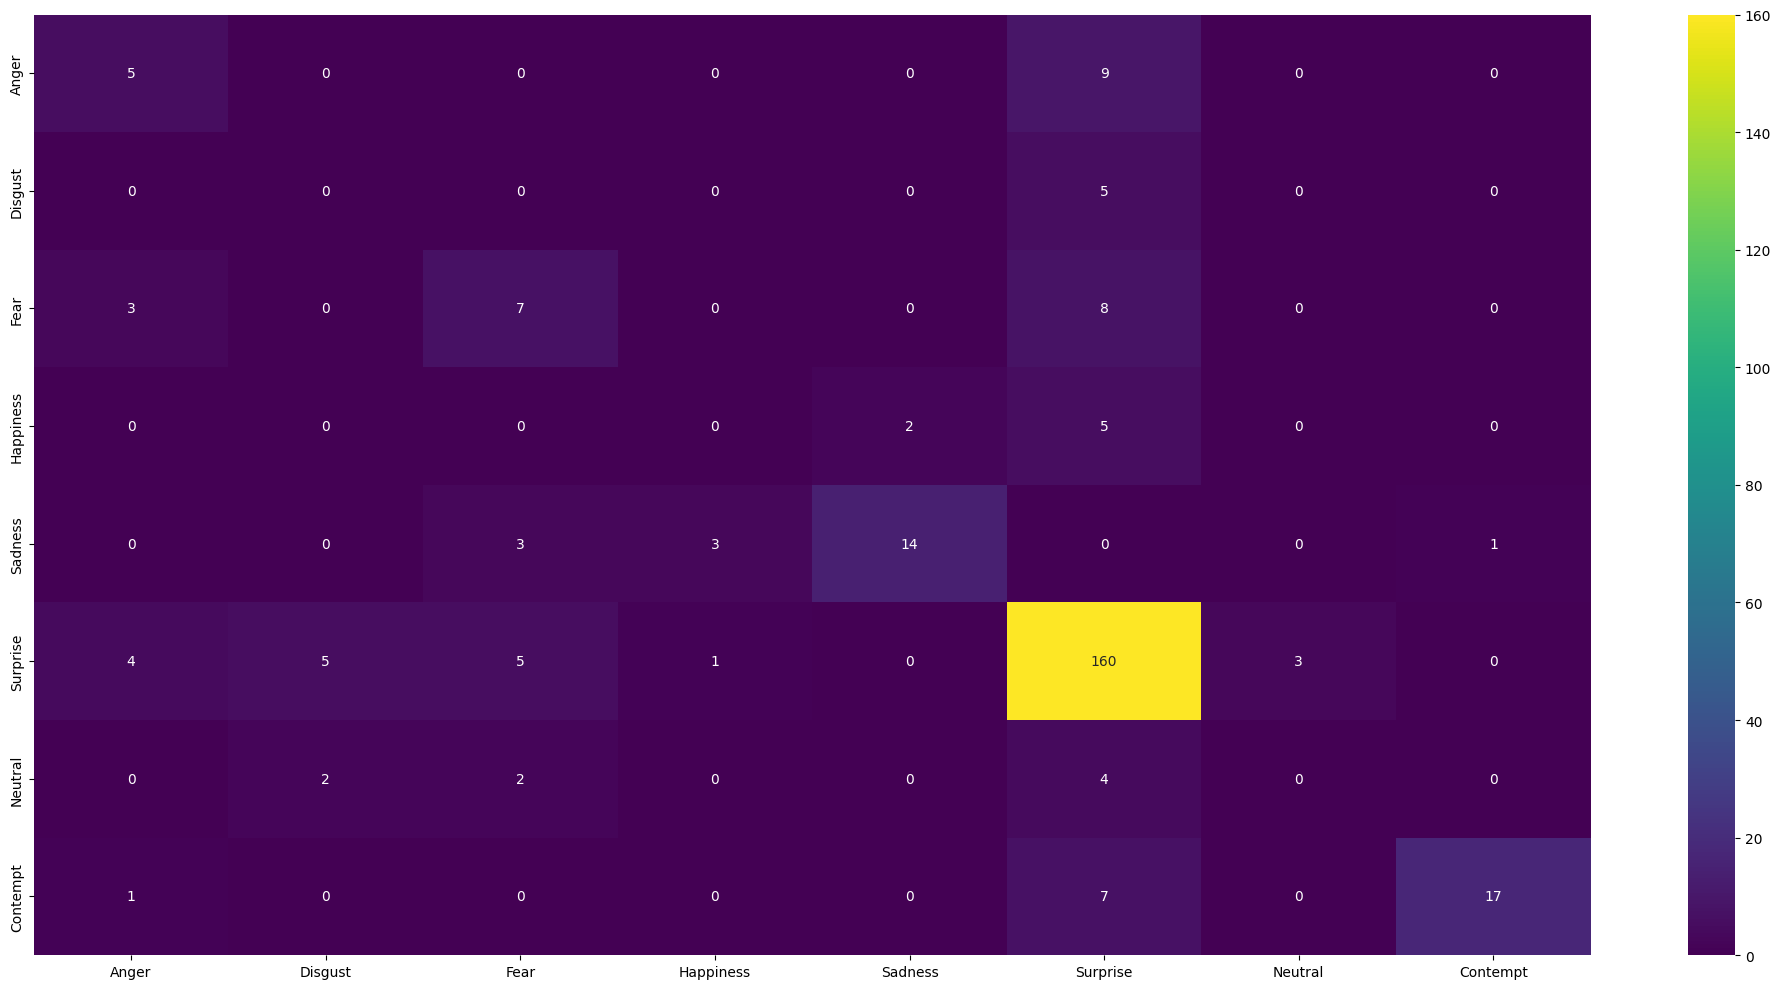

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

cm = confusion_matrix(y_pred=final_pred, y_true=y_test_final)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.show()

This model performed the worst to be honest in terms of f1 macro avg (0.4)
The reason is that, suppose the model misclassifies non neutral as neutral, then it doesnt get a chance to be evaluated by the second model. And since the model is biased towards neutral class, this condition is bound to happen. 

Although I kinda knew this was gonna happen, I just wanted to try it anyway